<a href="https://colab.research.google.com/github/Rajesh-Kumar-Biradar/WorthSync---Rajesh/blob/main/Employee_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the data
import pandas as pd
df = pd.read_csv('ai_job_dataset.csv')
print(df.head())

    job_id              job_title  salary_usd salary_currency  \
0  AI00001  AI Research Scientist       90376             USD   
1  AI00002   AI Software Engineer       61895             USD   
2  AI00003          AI Specialist      152626             USD   
3  AI00004           NLP Engineer       80215             USD   
4  AI00005          AI Consultant       54624             EUR   

  experience_level employment_type company_location company_size  \
0               SE              CT            China            M   
1               EN              CT           Canada            M   
2               MI              FL      Switzerland            L   
3               SE              FL            India            M   
4               EN              PT           France            S   

  employee_residence  remote_ratio  \
0              China            50   
1            Ireland           100   
2        South Korea             0   
3              India            50   
4         

In [3]:
import pandas as pd

# Calculate percentage of missing values per column
missing_percent = df.isnull().mean() * 100

# Display
print(missing_percent.sort_values())

job_id                    0.0
job_title                 0.0
salary_usd                0.0
salary_currency           0.0
experience_level          0.0
employment_type           0.0
company_location          0.0
company_size              0.0
employee_residence        0.0
remote_ratio              0.0
required_skills           0.0
education_required        0.0
years_experience          0.0
industry                  0.0
posting_date              0.0
application_deadline      0.0
job_description_length    0.0
benefits_score            0.0
company_name              0.0
dtype: float64


In [4]:
import pandas as pd
from typing import Tuple

def preprocess_for_modeling(filepath: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Loads and preprocesses the AI job dataset from a specified file path.

    This function performs the following steps:
    1.  Loads the data.
    2.  Engineers features from dates (posting_year, posting_month).
    3.  Creates one-hot encoded features from the 'required_skills' column.
    4.  Applies one-hot encoding to other key categorical features.
    5.  Separates the data into features (X) and target (y).
    6.  Drops irrelevant, redundant, or high-cardinality columns.

    Args:
        filepath: The path to the ai_job_dataset.csv file.

    Returns:
        A tuple containing two pandas objects:
        - X: DataFrame of preprocessed features ready for model training.
        - y: Series containing the target variable (salary_usd).
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file at '{filepath}' was not found.")
        return None, None

    df = df.copy()

    # --- 2. Date Feature Engineering ---
    df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
    df['posting_year'] = df['posting_date'].dt.year
    df['posting_month'] = df['posting_date'].dt.month

    # --- 3. Skill Feature Engineering ---
    top_skills = [
        'Python', 'AWS', 'SQL', 'TensorFlow', 'PyTorch', 'Java',
        'R', 'Tableau', 'Power BI', 'Docker', 'Kubernetes', 'NLP'
    ]
    for skill in top_skills:
        col_name = f'skill_{skill.lower().replace(" ", "_")}'
        df[col_name] = df['required_skills'].str.contains(skill, case=False, na=False).astype(int)

    # --- 4. Categorical Feature Encoding ---
    cat_cols_to_encode = ['experience_level', 'employment_type', 'company_size', 'education_required', 'industry']
    df = pd.get_dummies(df, columns=cat_cols_to_encode, prefix=cat_cols_to_encode, drop_first=True)

    # --- 5. Define Target and Drop Unnecessary Columns ---
    y = df['salary_usd']

    columns_to_drop = [
        'job_id', 'job_title', 'salary_currency', 'required_skills',
        'company_name', 'company_location', 'employee_residence',
        'application_deadline', 'posting_date', 'salary_usd'
    ]

    X = df.drop(columns=columns_to_drop)

    return X, y

# This block allows the script to be run directly to test the function
if __name__ == '__main__':
    FILEPATH = 'ai_job_dataset.csv'

    X_processed, y_target = preprocess_for_modeling(FILEPATH)

    if X_processed is not None:
        print("✅ Preprocessing Complete!")
        print("\nShape of the final feature matrix (X):", X_processed.shape)
        print("Shape of the final target vector (y):", y_target.shape)

        print("\n--- First 5 rows of the preprocessed features (X) ---")
        print(X_processed.head())

        print("\n--- Columns in the final feature set ---")
        print(X_processed.columns.tolist())

✅ Preprocessing Complete!

Shape of the final feature matrix (X): (15000, 43)
Shape of the final target vector (y): (15000,)

--- First 5 rows of the preprocessed features (X) ---
   remote_ratio  years_experience  job_description_length  benefits_score  \
0            50                 9                    1076             5.9   
1           100                 1                    1268             5.2   
2             0                 2                    1974             9.4   
3            50                 7                    1345             8.6   
4           100                 0                    1989             6.6   

   posting_year  posting_month  skill_python  skill_aws  skill_sql  \
0          2024             10             0          0          0   
1          2024             11             1          1          0   
2          2025              3             0          0          0   
3          2024             12             1          0          1   
4      

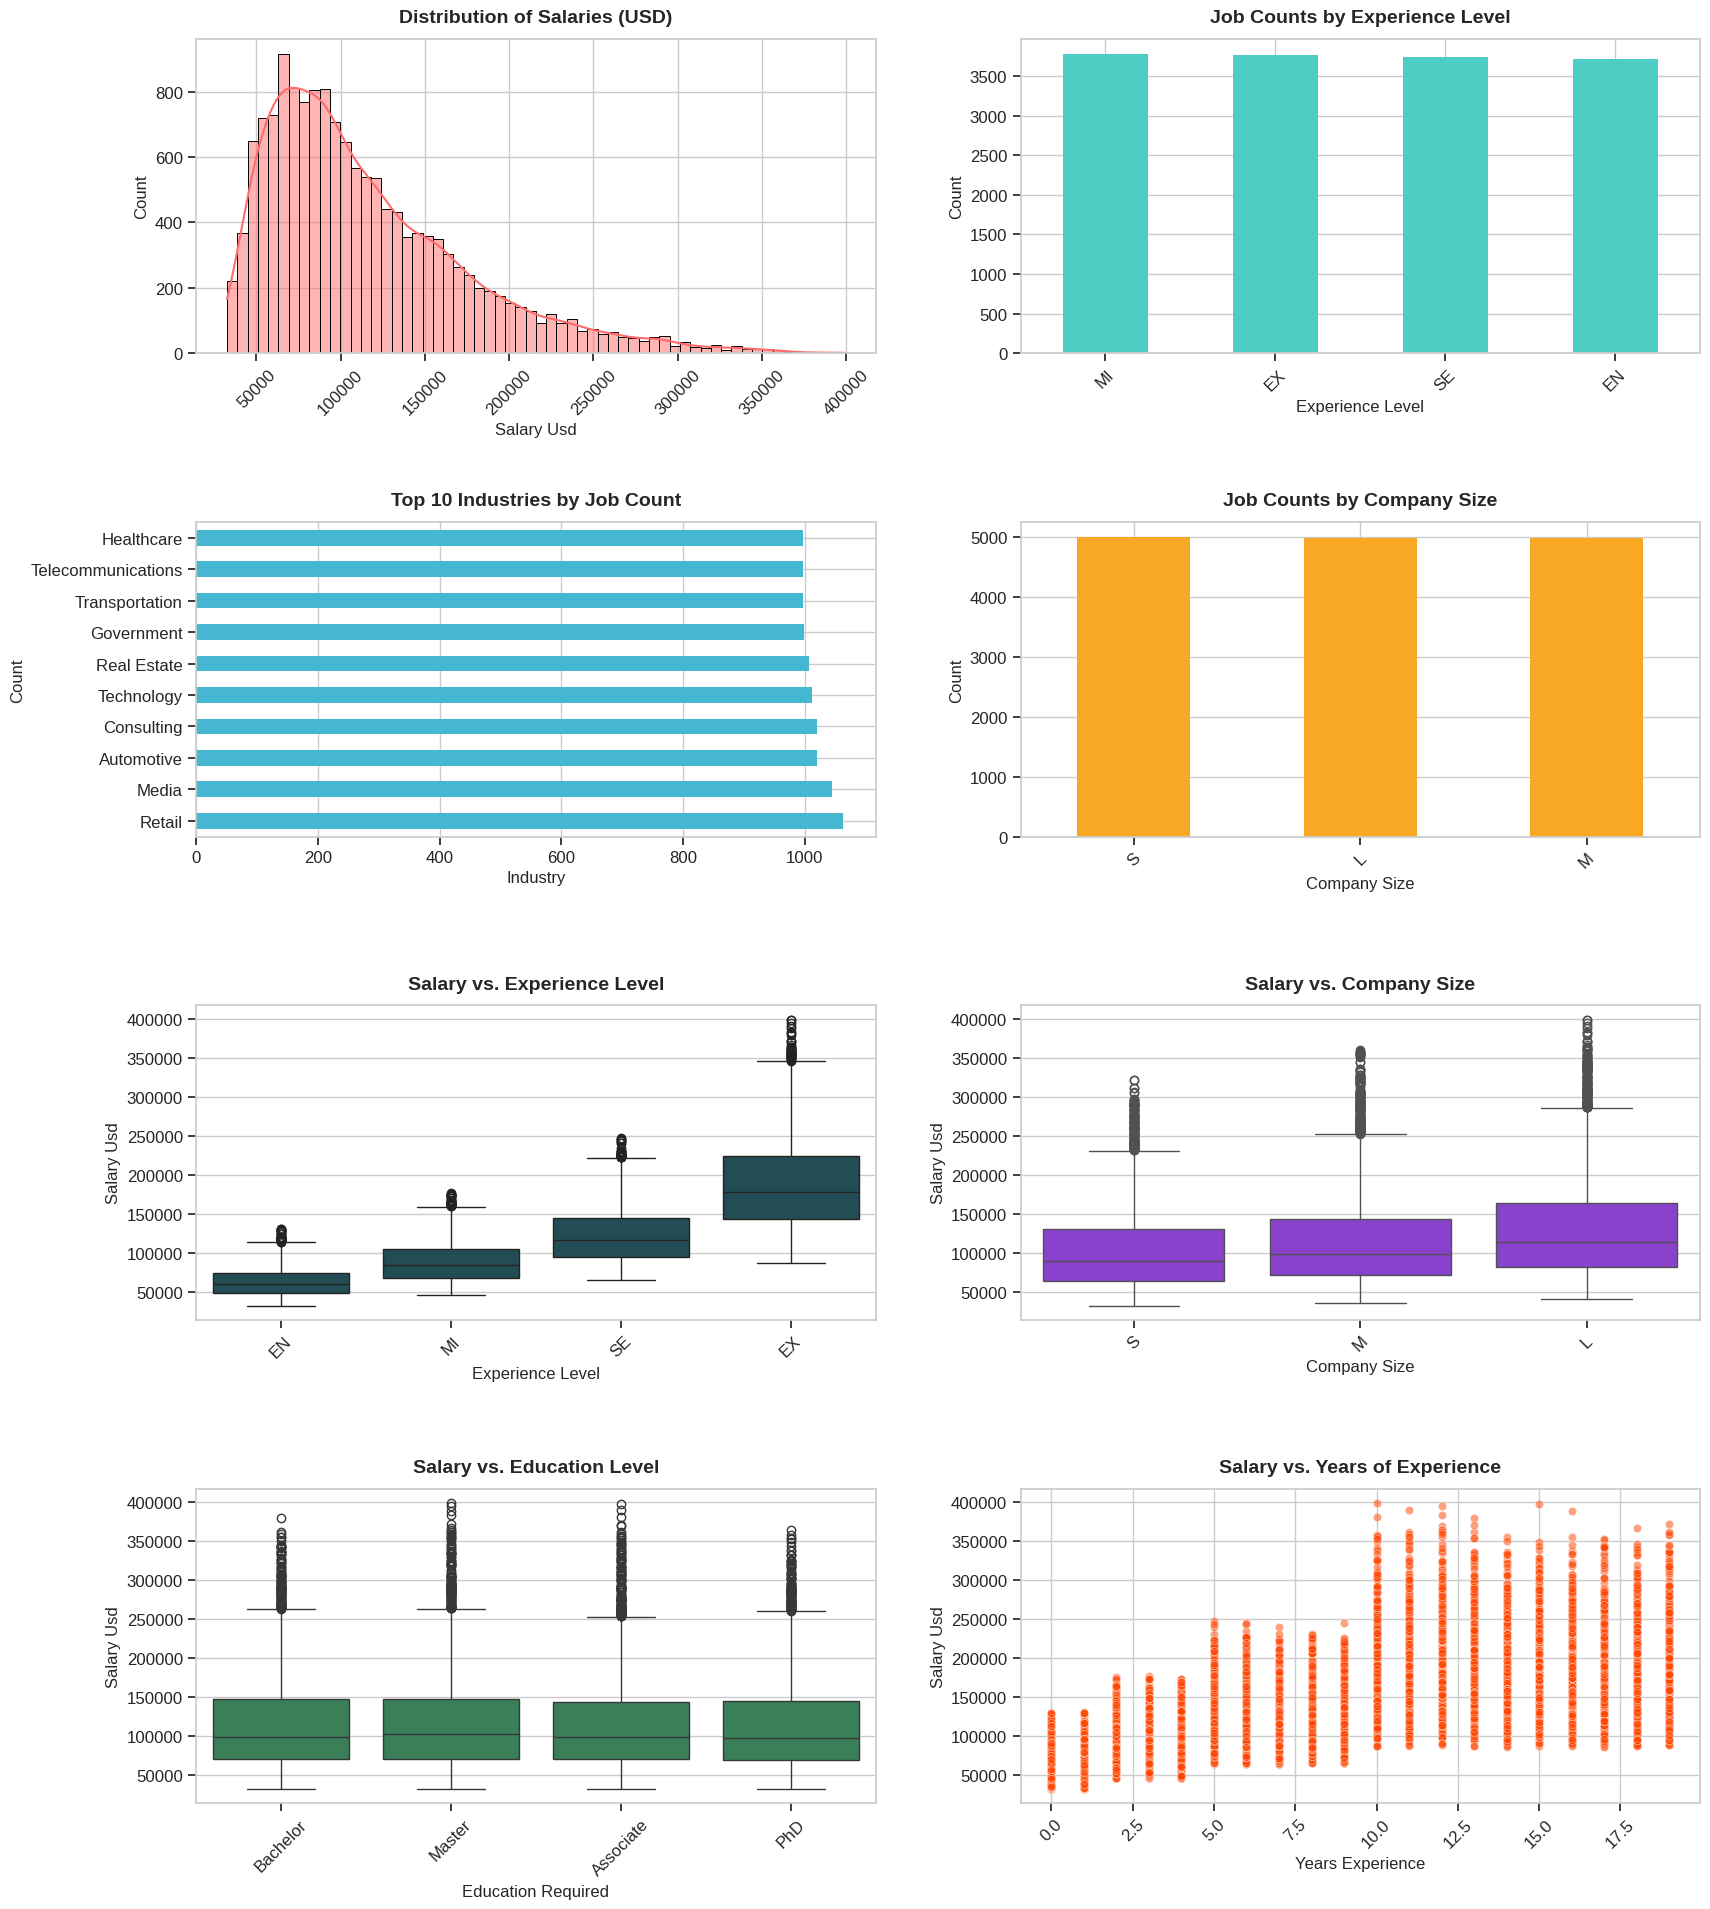

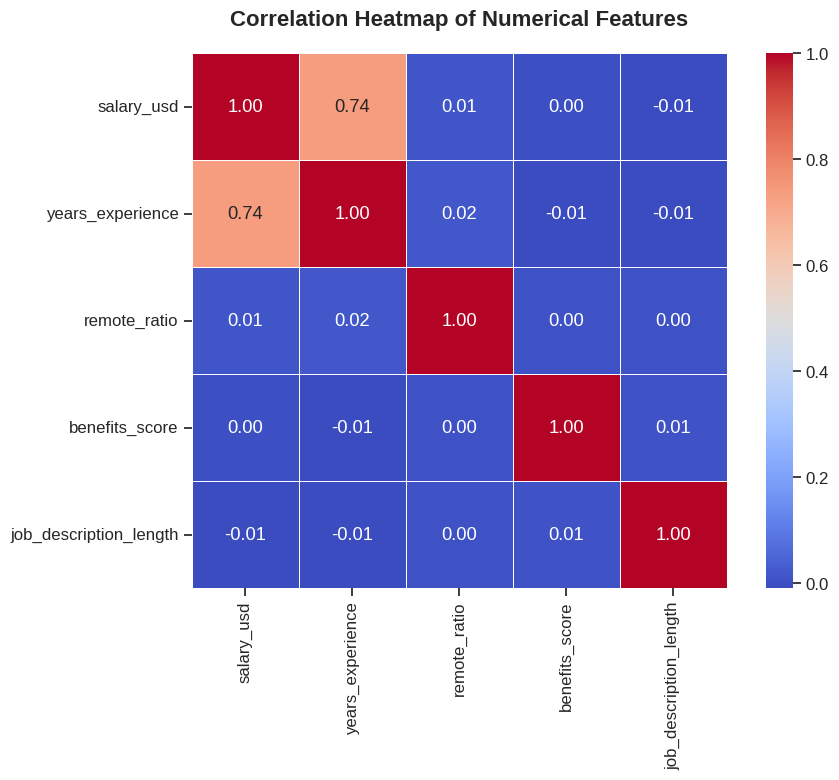

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_and_visualize_salaries(filepath: str):
    """
    Performs a comprehensive Exploratory Data Analysis (EDA) on the AI job dataset.

    This function loads, preprocesses, and visualizes the data to uncover key
    insights about salary predictors. It generates and saves two main visuals:
    1. A summary grid of key feature distributions and relationships.
    2. A correlation heatmap of numerical features.

    Args:
        filepath: The path to the ai_job_dataset.csv file.
    """

    # --- 1. Load and Preprocess Data ---
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file at '{filepath}' was not found. Please upload it and try again.")
        return

    # Enforce a logical order for key categorical variables for intuitive plots
    experience_order = ['EN', 'MI', 'SE', 'EX']  # Entry -> Mid -> Senior -> Executive
    size_order = ['S', 'M', 'L']                  # Small -> Medium -> Large
    df['experience_level'] = pd.Categorical(df['experience_level'], categories=experience_order, ordered=True)
    df['company_size'] = pd.Categorical(df['company_size'], categories=size_order, ordered=True)

    # --- 2. Define Plot Configurations ---
    # This list defines every plot we want to create in our main grid
    plot_configs = [
        # Univariate plots to understand individual feature distributions
        {'type': 'hist', 'column': 'salary_usd', 'title': 'Distribution of Salaries (USD)', 'color': '#FF6B6B'},
        {'type': 'bar', 'column': 'experience_level', 'title': 'Job Counts by Experience Level', 'color': '#4ECDC4'},
        {'type': 'barh', 'column': 'industry', 'title': 'Top 10 Industries by Job Count', 'color': '#45B7D1', 'top_n': 10},
        {'type': 'bar', 'column': 'company_size', 'title': 'Job Counts by Company Size', 'color': '#F9A825'},

        # Bivariate plots to understand relationships with salary
        {'type': 'box', 'column': 'experience_level', 'y_var': 'salary_usd', 'title': 'Salary vs. Experience Level', 'color': '#1A535C'},
        {'type': 'box', 'column': 'company_size', 'y_var': 'salary_usd', 'title': 'Salary vs. Company Size', 'color': '#8A2BE2'},
        {'type': 'box', 'column': 'education_required', 'y_var': 'salary_usd', 'title': 'Salary vs. Education Level', 'color': '#2E8B57'},
        {'type': 'scatter', 'column': 'years_experience', 'y_var': 'salary_usd', 'title': 'Salary vs. Years of Experience', 'color': '#FF4500'},
    ]

    # --- 3. Create the Main Visualization Grid ---
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.1)

    n_plots = len(plot_configs)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, config in enumerate(plot_configs):
        ax = axes[i]
        plot_type = config['type']
        col = config['column']

        if plot_type == 'hist':
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color=config['color'], edgecolor='black')
        elif plot_type == 'bar' or plot_type == 'barh':
            data = df[col].value_counts()
            if 'top_n' in config:
                data = data.nlargest(config['top_n'])
            data.plot(kind=plot_type, ax=ax, color=config['color'])
        elif plot_type == 'box':
            sns.boxplot(x=df[col], y=df[config['y_var']], ax=ax, color=config['color'])
        elif plot_type == 'scatter':
             sns.scatterplot(x=df[col], y=df[config['y_var']], ax=ax, color=config['color'], alpha=0.5)

        ax.set_title(config['title'], fontsize=14, weight='bold', pad=12)
        ax.set_xlabel(col.replace('_', ' ').title(), fontsize=12)
        ax.set_ylabel(config.get('y_var', 'Count').replace('_', ' ').title(), fontsize=12)

        if plot_type != 'barh':
            ax.tick_params(axis='x', rotation=45)

    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(pad=3.0)
    fig.savefig("eda_summary_plots.png", dpi=300)
    plt.show()

    # --- 4. Create the Correlation Heatmap ---
    correlation_cols = ['salary_usd', 'years_experience', 'remote_ratio', 'benefits_score', 'job_description_length']
    corr = df[correlation_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
    plt.title("Correlation Heatmap of Numerical Features", fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png", dpi=300)
    plt.show()

# --- Run the Analysis ---
if __name__ == '__main__':
    FILEPATH = 'ai_job_dataset.csv'
    analyze_and_visualize_salaries(FILEPATH)

🔍 Starting feature importance analysis with LightGBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 42
[LightGBM] [Info] Start training from score 115164.424333
✅ LightGBM model trained successfully!


/tmp/ipython-input-3987414803.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='Spectral')


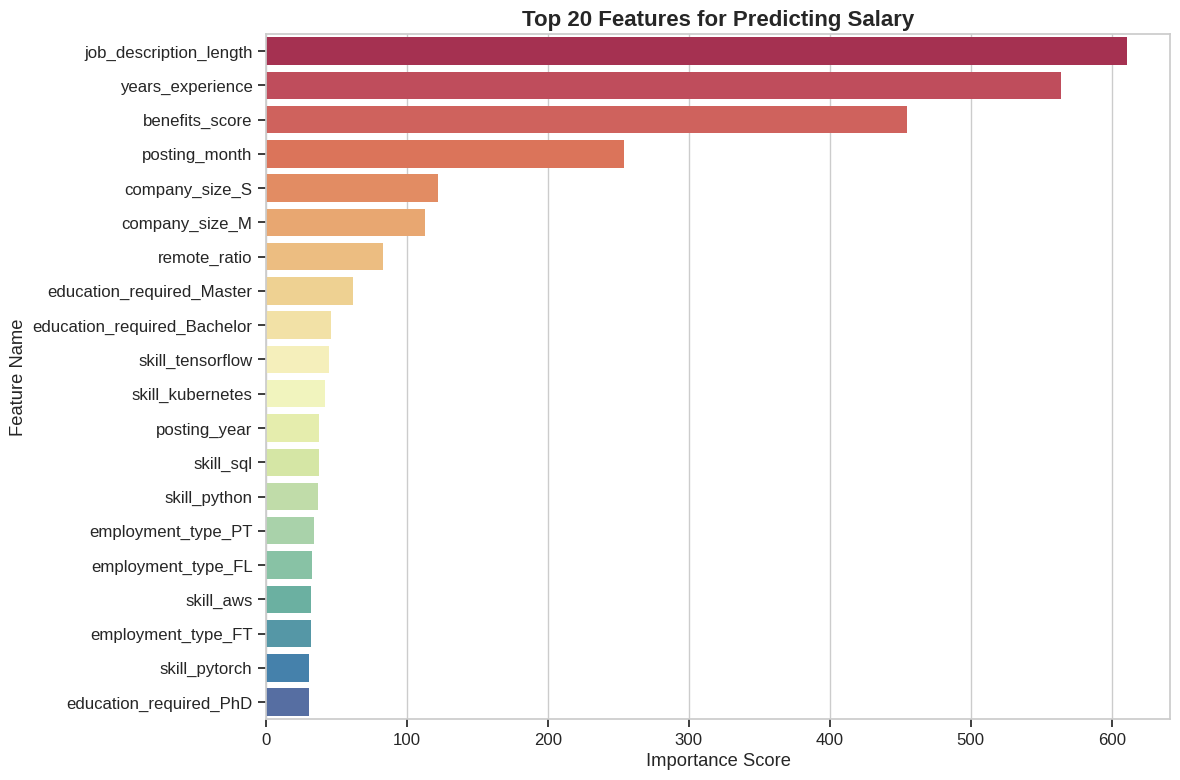


📌 Top 20 Features:
                        Feature  Importance
0        job_description_length         611
1              years_experience         564
2                benefits_score         455
3                 posting_month         254
4                company_size_S         122
5                company_size_M         113
6                  remote_ratio          83
7     education_required_Master          62
8   education_required_Bachelor          46
9              skill_tensorflow          45
10             skill_kubernetes          42
11                 posting_year          38
12                    skill_sql          38
13                 skill_python          37
14           employment_type_PT          34
15           employment_type_FL          33
16                    skill_aws          32
17           employment_type_FT          32
18                skill_pytorch          31
19       education_required_PhD          31

🎯 Feature selection process completed.

💾 Saved final d

In [6]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from typing import Tuple

# --- Function 1: Preprocessing ---
def preprocess_for_modeling(filepath: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Loads and preprocesses the AI job dataset from a specified file path.
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file at '{filepath}' was not found.")
        return None, None

    df = df.copy()

    df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
    df['posting_year'] = df['posting_date'].dt.year
    df['posting_month'] = df['posting_date'].dt.month

    top_skills = [
        'Python', 'AWS', 'SQL', 'TensorFlow', 'PyTorch', 'Java',
        'R', 'Tableau', 'Power BI', 'Docker', 'Kubernetes', 'NLP'
    ]
    for skill in top_skills:
        col_name = f'skill_{skill.lower().replace(" ", "_")}'
        df[col_name] = df['required_skills'].str.contains(skill, case=False, na=False).astype(int)

    cat_cols_to_encode = ['experience_level', 'employment_type', 'company_size', 'education_required', 'industry']
    df = pd.get_dummies(df, columns=cat_cols_to_encode, prefix=cat_cols_to_encode, drop_first=True)

    y = df['salary_usd']

    columns_to_drop = [
        'job_id', 'job_title', 'salary_currency', 'required_skills',
        'company_name', 'company_location', 'employee_residence',
        'application_deadline', 'posting_date', 'salary_usd'
    ]

    X = df.drop(columns=columns_to_drop)
    return X, y

# --- Function 2: Feature Analysis ---
def analyze_and_select_features(X: pd.DataFrame, y: pd.Series, top_n: int = 20) -> pd.DataFrame:
    """
    Trains a LightGBM model to find and return the top N most important features.
    """
    print("🔍 Starting feature importance analysis with LightGBM...\n")

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    print("✅ LightGBM model trained successfully!")

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    top_features_df = feature_importance_df.head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='Spectral')
    plt.title(f"Top {top_n} Features for Predicting Salary", fontsize=16, weight='bold')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

    print(f"\n📌 Top {top_n} Features:")
    print(top_features_df)

    selected_features = top_features_df['Feature'].tolist()
    X_selected = X[selected_features]

    print("\n🎯 Feature selection process completed.\n")
    return X_selected


# --- This is where you add the corrected block ---
if __name__ == '__main__':
    FILEPATH = 'ai_job_dataset.csv'

    # 1. Run the preprocessing function to create the datasets
    X_processed, y_target = preprocess_for_modeling(FILEPATH)

    # 2. Check if preprocessing was successful before proceeding
    if X_processed is not None and y_target is not None:

        # 3. Pass the results directly to the feature analysis function
        X_final = analyze_and_select_features(X_processed, y_target, top_n=20)

        # 4. Save the final datasets for the next step (final model training)
        joblib.dump(X_final, 'X_final_features.pkl')
        joblib.dump(y_target, 'y_target.pkl')
        print("💾 Saved final datasets: 'X_final_features.pkl' and 'y_target.pkl'")

✅ Successfully loaded final feature set and target.

⚙️ Performing 5-Fold Cross-Validation...
✅ Cross-Validation Complete!

📊 --- Final Model Performance ---
MAE for each fold: [27162.34 27814.27 26559.36 27150.7  27071.61]
-----------------------------------
💰 Average Mean Absolute Error (MAE): $27,151.66
🎯 MAE as a Percentage of Average Salary: 23.54%
⚖️ Standard Deviation of MAE: $399.10
-----------------------------------

🔍 **Interpretation:**
This model can predict salaries with an average error of approximately **$27,152**, which is about **24%** of the average salary in the dataset.
The low standard deviation of the error across different data splits indicates that the model's performance is **stable and reliable**.


/tmp/ipython-input-529744632.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Fold', y='MAE', data=score_df, palette='viridis', width=0.6)


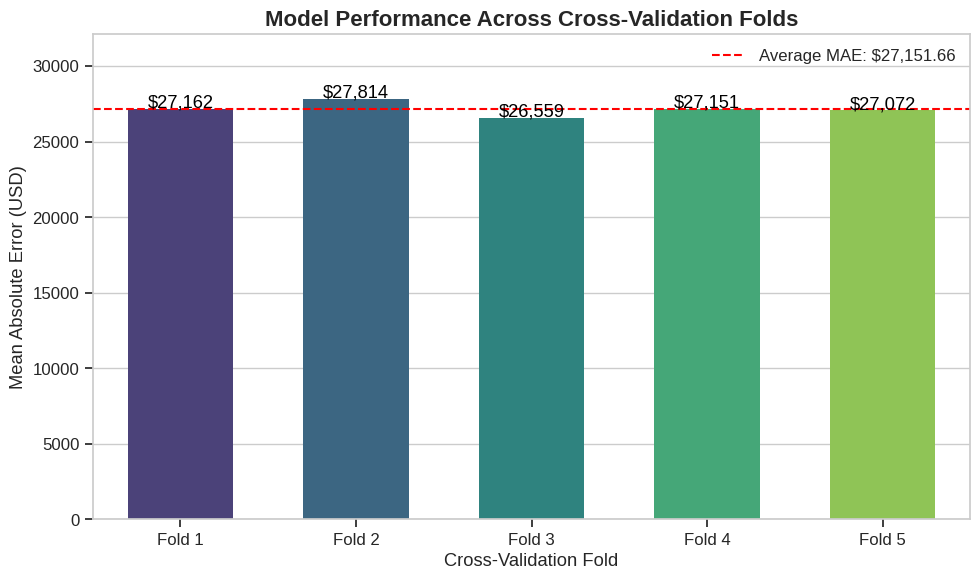

In [7]:
# ------------------- Imports -------------------
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- Function: Evaluate and Interpret Model -------------------
def evaluate_and_interpret_model(X_path='X_final_features.pkl', y_path='y_target.pkl', cv=5):
    """
    Loads the final feature set, evaluates the model using K-Fold Cross-Validation,
    and provides a detailed, interpretable analysis of its performance.

    Args:
        X_path (str): Path to the final feature matrix (.pkl file).
        y_path (str): Path to the final target vector (.pkl file).
        cv (int): The number of folds for cross-validation.
    """
    # --- Load Data ---
    try:
        X = joblib.load(X_path)
        y = joblib.load(y_path)
        print("✅ Successfully loaded final feature set and target.")
    except FileNotFoundError:
        print(f"❌ Error: Could not find '{X_path}' or '{y_path}'. Please run previous steps.")
        return

    # --- Initialize Model ---
    model = lgb.LGBMRegressor(random_state=42, verbosity=-1) # verbosity=-1 silences training output

    # --- Perform K-Fold Cross-Validation ---
    print(f"\n⚙️ Performing {cv}-Fold Cross-Validation...")
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    mae_scores = -scores
    print("✅ Cross-Validation Complete!")

    # --- Calculate and Interpret Performance Metrics ---
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    avg_salary = y.mean()
    relative_mae = (mean_mae / avg_salary) * 100

    print("\n📊 --- Final Model Performance ---")
    print(f"MAE for each fold: {np.round(mae_scores, 2)}")
    print("-" * 35)
    print(f"💰 Average Mean Absolute Error (MAE): ${mean_mae:,.2f}")
    print(f"🎯 MAE as a Percentage of Average Salary: {relative_mae:.2f}%")
    print(f"⚖️ Standard Deviation of MAE: ${std_mae:,.2f}")
    print("-" * 35)

    print("\n🔍 **Interpretation:**")
    print(f"This model can predict salaries with an average error of approximately **${mean_mae:,.0f}**, which is about **{relative_mae:.0f}%** of the average salary in the dataset.")
    print("The low standard deviation of the error across different data splits indicates that the model's performance is **stable and reliable**.")

    # --- Create an Attractive Visualization ---
    plt.figure(figsize=(10, 6))
    score_df = pd.DataFrame({'Fold': [f'Fold {i+1}' for i in range(cv)], 'MAE': mae_scores})

    # Create the bar plot
    barplot = sns.barplot(x='Fold', y='MAE', data=score_df, palette='viridis', width=0.6)

    # Add a line for the average MAE
    plt.axhline(mean_mae, color='red', linestyle='--', label=f'Average MAE: ${mean_mae:,.2f}')

    # Add value labels on top of each bar
    for index, row in score_df.iterrows():
        barplot.text(row.name, row.MAE + 100, f'${row.MAE:,.0f}', color='black', ha="center")

    plt.title("Model Performance Across Cross-Validation Folds", fontsize=16, weight='bold')
    plt.ylabel("Mean Absolute Error (USD)")
    plt.xlabel("Cross-Validation Fold")
    plt.ylim(top=plt.ylim()[1] * 1.1) # Add some space at the top
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------- Run the Final Evaluation -------------------
if __name__ == '__main__':
    evaluate_and_interpret_model(cv=5)

In [8]:
# -------------------- Imports --------------------
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import joblib
import numpy as np

# -------------------- Function: Load Data --------------------
def load_data(X_path='X_final_features.pkl', y_path='y_target.pkl'):
    """Loads the final feature set and target variable from saved files."""
    try:
        X = joblib.load(X_path)
        y = joblib.load(y_path)
        print("✅ Successfully loaded final feature set and target.")
        return X, y
    except FileNotFoundError:
        print(f"❌ Error: Could not find '{X_path}' or '{y_path}'. Please run previous steps.")
        return None, None

# -------------------- Function: Tune and Evaluate Model --------------------
def tune_and_evaluate_lgbm(X, y, n_iter=20, cv=5):
    """
    Performs hyperparameter tuning for a LightGBM model using RandomizedSearchCV
    and evaluates the best model found.

    Args:
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target variable.
        n_iter (int): Number of parameter settings that are sampled.
        cv (int): Number of folds for cross-validation.
    """
    print(f"\n⚙️ Starting hyperparameter tuning (n_iter={n_iter}, cv={cv})...")

    # Define the hyperparameter grid to search
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40, 50],
        'max_depth': [-1, 10, 20],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'subsample': [0.7, 0.8, 0.9, 1.0],
    }

    # Initialize the model and the search
    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=cv,
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    )

    # Fit the search to the data
    random_search.fit(X, y)
    print("✅ Tuning complete!")

    # --- Results ---
    print("\n--- Best Hyperparameters Found ---")
    print(random_search.best_params_)

    # Evaluate the best model found by the search
    best_model = random_search.best_estimator_
    predictions = best_model.predict(X)
    final_mae = mean_absolute_error(y, predictions)

    print("\n--- Performance of the Tuned Model ---")
    print(f"💰 Final Mean Absolute Error (MAE) with tuned model: ${final_mae:,.2f}")

    # --- Save the Final Tuned Model ---
    joblib.dump(best_model, 'tuned_salary_prediction_model.pkl')
    print("\n💾 Final, tuned model saved as 'tuned_salary_prediction_model.pkl'")

# -------------------- Main Execution Block --------------------
if __name__ == '__main__':
    X_final, y_target = load_data()

    if X_final is not None:
        tune_and_evaluate_lgbm(X_final, y_target)

✅ Successfully loaded final feature set and target.

⚙️ Starting hyperparameter tuning (n_iter=20, cv=5)...
✅ Tuning complete!

--- Best Hyperparameters Found ---
{'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

--- Performance of the Tuned Model ---
💰 Final Mean Absolute Error (MAE) with tuned model: $25,958.28

💾 Final, tuned model saved as 'tuned_salary_prediction_model.pkl'


In [9]:
pip install sentence-transformers

In [1]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer

def create_full_nlp_features(filepath: str):
    """
    Creates a master feature set with both structured data and NLP embeddings
    from 'job_title' and 'required_skills' columns.

    Args:
        filepath (str): Path to the raw dataset CSV.

    Returns:
        X (pd.DataFrame): Final feature matrix.
        y (pd.Series): Target variable (salary_usd).
    """

    # --- 1. Load Raw Data ---
    print("📥 Step 1: Loading raw dataset...")
    try:
        df_raw = pd.read_csv(filepath)
        print(f"✅ Loaded data with shape: {df_raw.shape}")
    except FileNotFoundError:
        print(f"❌ File not found: {filepath}")
        return None, None

    # --- 2. Preprocessing Structured Features ---
    print("🔧 Step 2: Preprocessing structured features...")
    df = df_raw.copy()
    df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
    df['posting_year'] = df['posting_date'].dt.year
    df['posting_month'] = df['posting_date'].dt.month

    categorical_columns = ['experience_level', 'employment_type', 'company_size', 'education_required', 'industry']
    df[categorical_columns] = df[categorical_columns].astype('category')  # Optimized memory
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    y = df['salary_usd']

    drop_columns = [
        'salary_usd', 'job_id', 'job_title', 'salary_currency', 'required_skills',
        'company_name', 'company_location', 'employee_residence',
        'application_deadline', 'posting_date'
    ]
    X_structured = df.drop(columns=drop_columns)
    print(f"✅ Structured features shape: {X_structured.shape}")

    # --- 3. Generate NLP Embeddings ---
    print("🧠 Step 3: Generating NLP embeddings using Sentence-BERT...")
    model = SentenceTransformer('all-MiniLM-L6-v2')

    def encode_column(text_series, prefix):
        print(f"🔍 Encoding '{prefix}' column...")
        embeddings = model.encode(text_series.fillna('').tolist(), show_progress_bar=True)
        return pd.DataFrame(embeddings, columns=[f"{prefix}_emb_{i}" for i in range(embeddings.shape[1])])

    title_embeddings_df = encode_column(df_raw['job_title'], 'title')
    skills_embeddings_df = encode_column(df_raw['required_skills'], 'skill')

    # --- 4. Combine All Features ---
    print("🔗 Step 4: Combining structured and NLP features...")
    X_combined = pd.concat([X_structured.reset_index(drop=True),
                            title_embeddings_df.reset_index(drop=True),
                            skills_embeddings_df.reset_index(drop=True)],
                           axis=1)

    print(f"✅ Final feature matrix shape: {X_combined.shape}")

    return X_combined, y

# --- Main Execution Block ---
if __name__ == '__main__':
    FILEPATH = 'ai_job_dataset.csv'
    X_master, y_master = create_full_nlp_features(FILEPATH)

    if X_master is not None:
        joblib.dump(X_master, 'X_master_features_full_nlp.pkl')
        joblib.dump(y_master, 'y_master_target_full_nlp.pkl')
        print("\n💾 Saved:")
        print("📁 'X_master_features_full_nlp.pkl'")
        print("📁 'y_master_target_full_nlp.pkl'")


📥 Step 1: Loading raw dataset...
✅ Loaded data with shape: (15000, 19)
🔧 Step 2: Preprocessing structured features...
✅ Structured features shape: (15000, 31)
🧠 Step 3: Generating NLP embeddings using Sentence-BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


🔍 Encoding 'title' column...


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🔍 Encoding 'skill' column...


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

🔗 Step 4: Combining structured and NLP features...
✅ Final feature matrix shape: (15000, 799)

💾 Saved:
📁 'X_master_features_full_nlp.pkl'
📁 'y_master_target_full_nlp.pkl'


📥 Step 1: Loading master datasets...
✅ Datasets loaded.
⚙️ Training LightGBM model to compute feature importance...
✅ Model trained successfully.
💾 Complete feature importance list saved to 'all_feature_importances.csv'
⚠️ Warning: 190 features have zero importance and could be dropped.


/tmp/ipython-input-839048464.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features_df, x='Importance', y='Feature', palette='plasma_r')


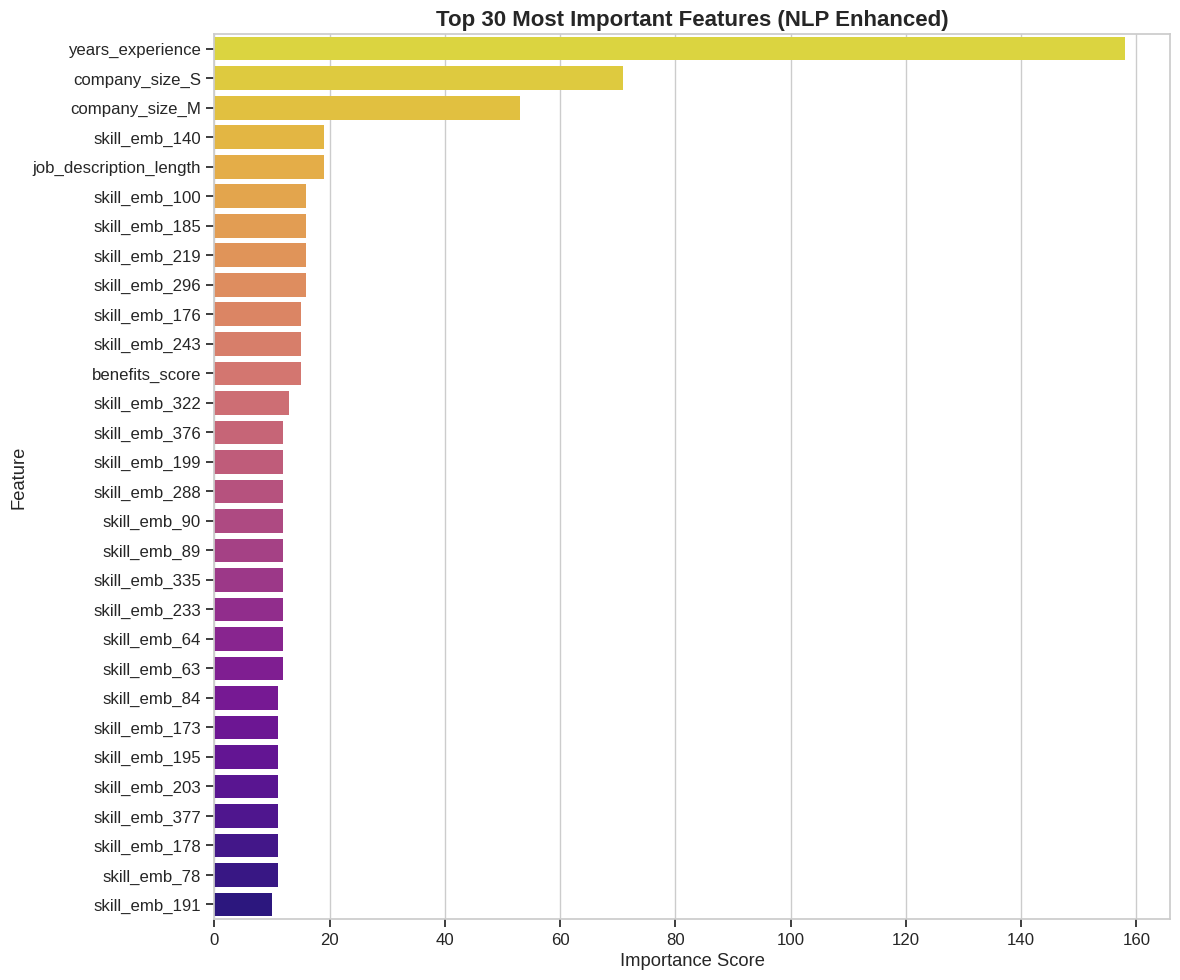


💾 Saved final selected features to: 'X_final_selected_features.pkl'
✅ Process complete. Selected 30 features.


In [10]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

def find_top_features(X: pd.DataFrame, y: pd.Series, top_n: int = 30) -> pd.DataFrame:
    """
    Trains a LightGBM model to find, visualize, and return the most important features.

    Args:
        X (pd.DataFrame): The full feature matrix.
        y (pd.Series): The target variable.
        top_n (int): The number of top features to identify and visualize.

    Returns:
        pd.DataFrame: A DataFrame containing the names and importance scores
                      of the top_n features.
    """
    # --- 1. Validate Inputs ---
    assert len(X) == len(y), "❌ Error: Mismatched lengths between X and y."
    top_n = min(top_n, X.shape[1])

    # --- 2. Train Model for Importance Analysis ---
    print("⚙️ Training LightGBM model to compute feature importance...")
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = lgb.LGBMRegressor(random_state=42, verbosity=-1, n_jobs=-1)
    model.fit(X_train, y_train)
    print("✅ Model trained successfully.")

    # --- 3. Compute and Save Importance ---
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    # Save the complete list of feature importances for deeper analysis
    importance_df.to_csv('all_feature_importances.csv', index=False)
    print("💾 Complete feature importance list saved to 'all_feature_importances.csv'")

    zero_importance_count = (importance_df['Importance'] == 0).sum()
    if zero_importance_count > 0:
        print(f"⚠️ Warning: {zero_importance_count} features have zero importance and could be dropped.")

    # --- 4. Visualize Top Features ---
    top_features_df = importance_df.head(top_n)

    plt.figure(figsize=(12, 10))
    sns.barplot(data=top_features_df, x='Importance', y='Feature', palette='plasma_r')
    plt.title(f"Top {top_n} Most Important Features (NLP Enhanced)", fontsize=16, weight='bold')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(f'top_{top_n}_feature_importance.png', dpi=300) # Corrected line
    plt.show()

    return top_features_df

# --- Main Execution Block ---
if __name__ == '__main__':
    X_MASTER_PATH = 'X_master_features_full_nlp.pkl'
    Y_MASTER_PATH = 'y_master_target_full_nlp.pkl'

    print("📥 Step 1: Loading master datasets...")
    if not os.path.exists(X_MASTER_PATH) or not os.path.exists(Y_MASTER_PATH):
        print(f"❌ Error: Could not find required files.")
    else:
        X_master = joblib.load(X_MASTER_PATH)
        y_master = joblib.load(Y_MASTER_PATH)
        X_master.columns = X_master.columns.astype(str)
        print("✅ Datasets loaded.")

        # --- Run Feature Importance Analysis ---
        top_features_info = find_top_features(X_master, y_master, top_n=30)

        # --- Select and Save Final Features ---
        final_feature_names = top_features_info['Feature'].tolist()
        X_final_selected = X_master[final_feature_names]

        joblib.dump(X_final_selected, 'X_final_selected_features.pkl')
        print("\n💾 Saved final selected features to: 'X_final_selected_features.pkl'")
        print(f"✅ Process complete. Selected {len(final_feature_names)} features.")

📥 Loading data...
✅ Data loaded.

⚙️ Evaluating models using 5-Fold Cross-Validation...
🔍 Evaluating Ridge...
🔍 Evaluating RandomForest...
🔍 Evaluating GradientBoosting...
🔍 Evaluating XGBoost...
🔍 Evaluating LightGBM...

🏆 Model Comparison Summary:
              Model           MAE          RMSE  R2 Score    Time (s)
2  GradientBoosting  26936.258837  36175.346245  0.643900   90.536903
4          LightGBM  27158.821426  36691.397672  0.632020    2.408974
1      RandomForest  27356.975146  36745.568079  0.629197  248.027298
3           XGBoost  28446.367578  38038.791148  0.591537    6.703954
0             Ridge  28587.002986  39745.627188  0.581411    0.178643


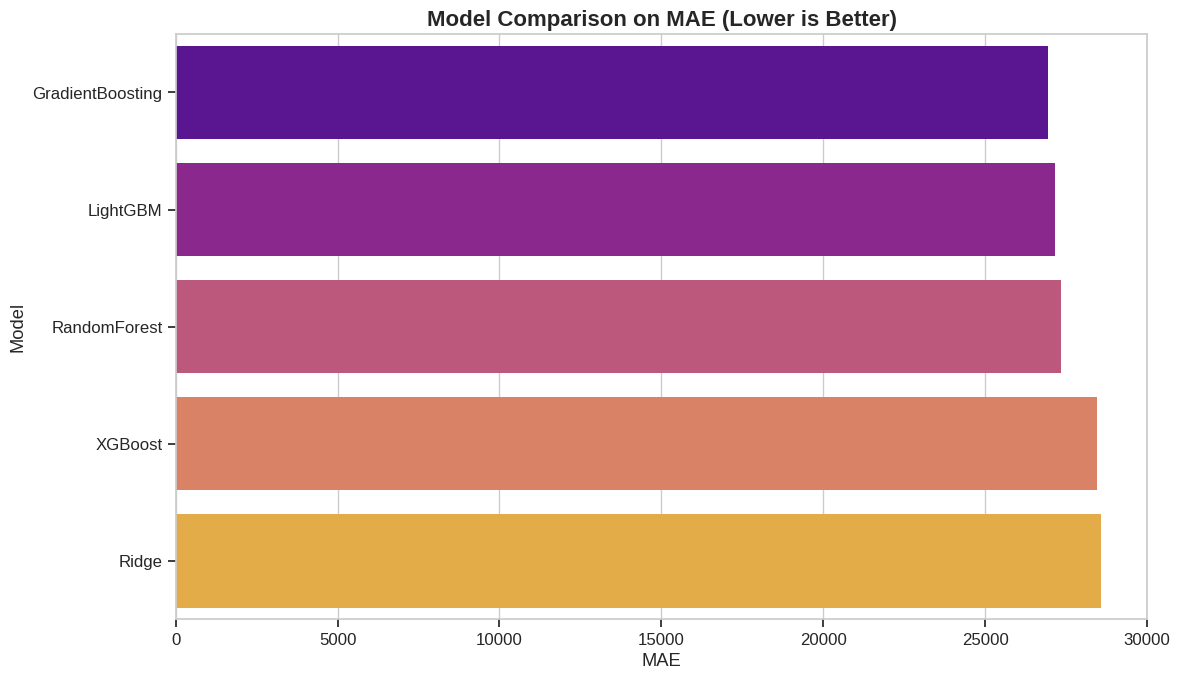

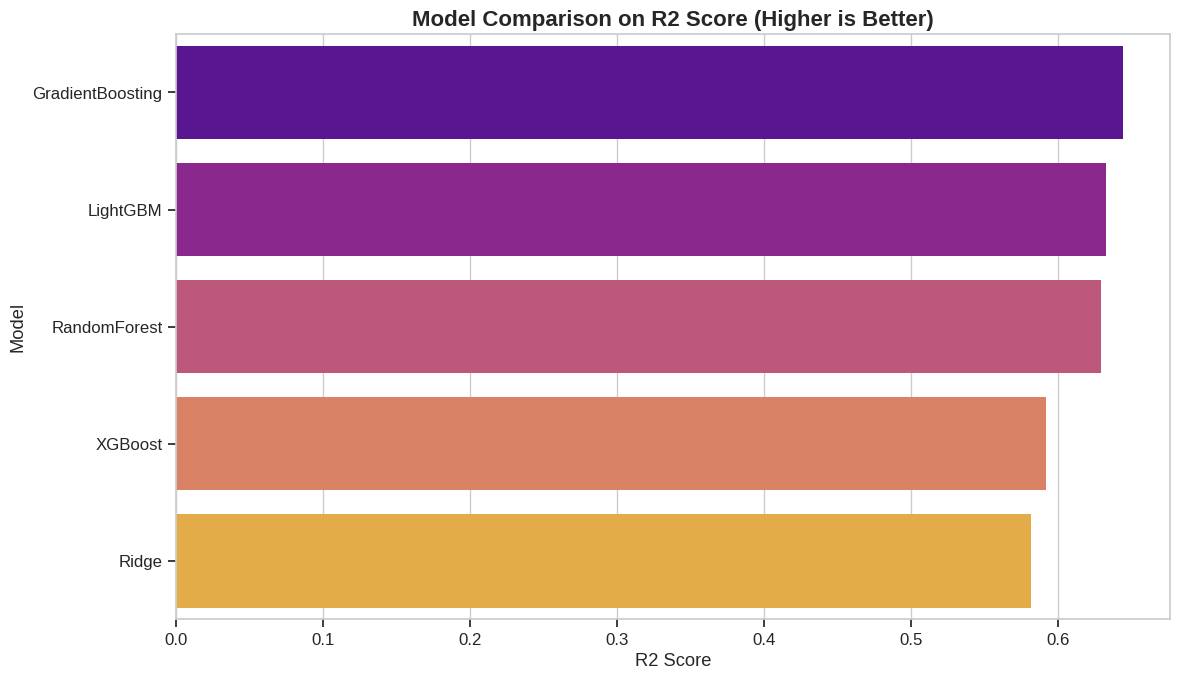

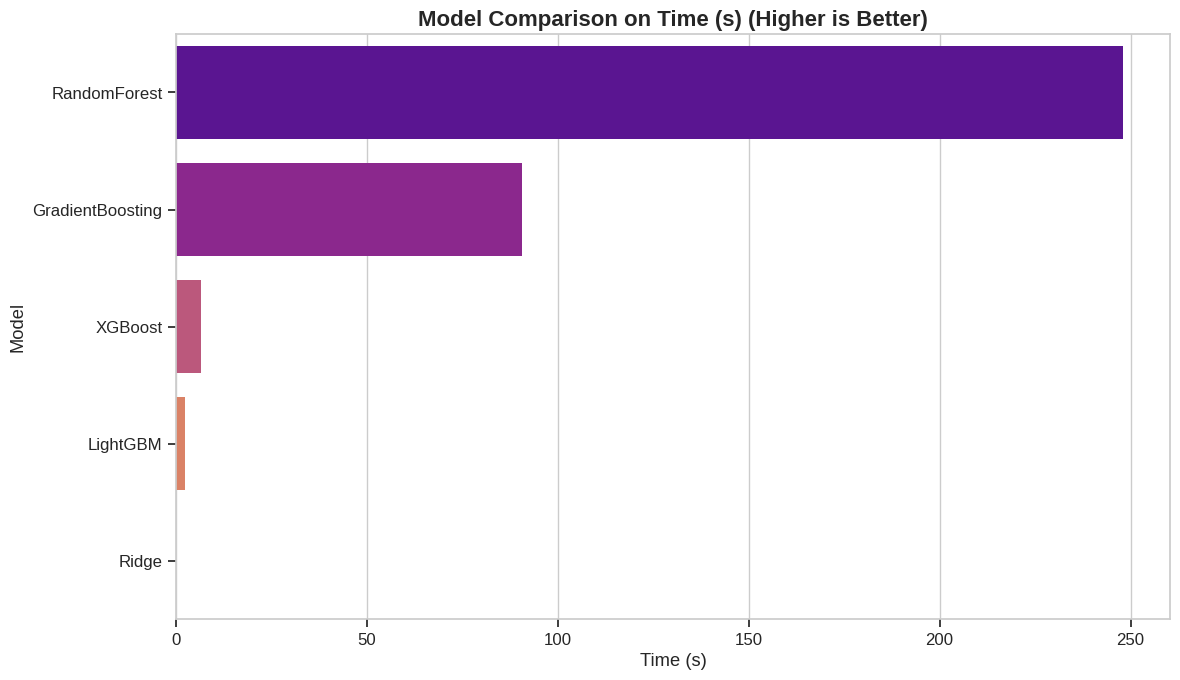

In [11]:
# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import joblib
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

# ------------------- Utility Function -------------------
def plot_metrics(df, metric: str, filename: str):
    """
    Creates and saves a horizontal bar plot for a given evaluation metric.
    """
    is_error_metric = metric in ['MAE', 'RMSE']
    df_sorted = df.sort_values(by=metric, ascending=is_error_metric)

    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_sorted, x=metric, y='Model', palette='plasma')
    plt.title(f"Model Comparison on {metric} ({'Lower' if is_error_metric else 'Higher'} is Better)",
              fontsize=16, weight='bold')
    plt.xlabel(metric)
    plt.ylabel("Model")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# ------------------- Main Execution -------------------
if __name__ == '__main__':
    # --- 1. Load Data ---
    print("📥 Loading data...")
    try:
        X = joblib.load('X_final_selected_features.pkl')
        y = joblib.load('y_master_target_full_nlp.pkl')
        print("✅ Data loaded.")
    except FileNotFoundError:
        print("❌ Error: Required data files not found.")
        exit()

    # --- 2. Scale Features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- 3. Define Models ---
    models = [
        ("Ridge", Ridge(random_state=42)),
        ("RandomForest", RandomForestRegressor(n_jobs=-1, random_state=42)),
        ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
        ("XGBoost", XGBRegressor(n_jobs=-1, random_state=42, verbosity=0)),
        ("LightGBM", LGBMRegressor(n_jobs=-1, random_state=42, verbosity=-1))
    ]

    # --- 4. Evaluate Models using K-Fold CV ---
    print("\n⚙️ Evaluating models using 5-Fold Cross-Validation...")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in models:
        print(f"🔍 Evaluating {name}...")
        start_time = time.time()

        mae_list, r2_list = [], []

        for train_index, test_index in kfold.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            mae_list.append(mean_absolute_error(y_test, preds))
            r2_list.append(r2_score(y_test, preds))

        elapsed_time = time.time() - start_time

        results.append({
            "Model": name,
            "MAE": np.mean(mae_list),
            "RMSE": np.sqrt(mean_squared_error(y_test, preds)),  # from last fold
            "R2 Score": np.mean(r2_list),
            "Time (s)": elapsed_time
        })

    # --- 5. Save and Display Results ---
    results_df = pd.DataFrame(results).sort_values(by='MAE')
    print("\n🏆 Model Comparison Summary:")
    print(results_df)

    results_df.to_csv("model_comparison_final_results.csv", index=False)

    # --- 6. Visualize Metrics ---
    plot_metrics(results_df, 'MAE', 'model_comparison_mae.png')
    plot_metrics(results_df, 'R2 Score', 'model_comparison_r2.png')
    plot_metrics(results_df, 'Time (s)', 'model_comparison_time.png')


In [12]:
# ------------------- Imports -------------------
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import time
import datetime
import numpy as np

# ------------------- Helper Functions -------------------

def save_model(model, base_filename='final_tuned_model'):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{base_filename}_{timestamp}.pkl"
    joblib.dump(model, filename)
    print(f"\n💾 Model saved as '{filename}'")

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print("\n--- Final Model Evaluation on Test Data ---")
    print(f"💰 Mean Absolute Error (MAE): {mae:.4f}")
    print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"📊 R^2 Score: {r2:.4f}")
    return mae, rmse, r2

# ------------------- Main Tuning Script -------------------
if __name__ == '__main__':
    print("📥 Loading final selected features...")
    try:
        X = joblib.load('X_final_selected_features.pkl')
        y = joblib.load('y_master_target_full_nlp.pkl')
        print("✅ Data loaded successfully.")
    except FileNotFoundError:
        print("❌ Error: Required data files not found.")
        exit()

    print("\nSplitting data into training and testing sets (80% train, 20% test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"✅ Data split complete. Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

    # --- Hyperparameter grid ---
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40, 50],
        'max_depth': [-1, 10, 20],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'min_child_samples': [10, 20, 30],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5]
    }

    print(f"\n⚙️ Starting hyperparameter tuning with {20} iterations and 5-fold CV...")

    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1, n_jobs=-1)

    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_grid,
        n_iter=20,
        scoring='neg_mean_absolute_error',
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()

    print(f"✅ Tuning complete! Time taken: {end_time - start_time:.2f} seconds.")

    print("\n--- Best Hyperparameters Found ---")
    for param, val in random_search.best_params_.items():
        print(f"  {param}: {val}")

    best_cv_mae = -random_search.best_score_
    print(f"\n📈 Best Cross-Validation MAE: {best_cv_mae:.4f}")

    best_model = random_search.best_estimator_

    # Evaluate on test data
    evaluate_model(best_model, X_test, y_test)

    # Save final model with timestamp
    save_model(best_model)

📥 Loading final selected features...
✅ Data loaded successfully.

Splitting data into training and testing sets (80% train, 20% test)...
✅ Data split complete. Training samples: 12000, Test samples: 3000

⚙️ Starting hyperparameter tuning with 20 iterations and 5-fold CV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Tuning complete! Time taken: 509.36 seconds.

--- Best Hyperparameters Found ---
  subsample: 1.0
  reg_lambda: 0.1
  reg_alpha: 0.5
  num_leaves: 40
  n_estimators: 500
  min_child_samples: 10
  max_depth: -1
  learning_rate: 0.01
  colsample_bytree: 1.0

📈 Best Cross-Validation MAE: 26912.1194

--- Final Model Evaluation on Test Data ---
💰 Mean Absolute Error (MAE): 27345.8355
📉 Root Mean Squared Error (RMSE): 36855.7804
📊 R^2 Score: 0.6276

💾 Model saved as 'final_tuned_model_20250730_185635.pkl'


📥 Loading final tuned model and feature set...
✅ Loaded model: './final_tuned_model_20250730_185635.pkl'
✅ Feature shape: (15000, 30)
⚠️ SHAP may be slow on large datasets. Sampling 2000 rows...

🔎 Explaining model of type: LGBMRegressor

⚙️ Calculating SHAP values...
✅ SHAP values calculated.

🏆 Top 5 Most Influential Features:


,Mean |SHAP| Value
years_experience,39721.001181
company_size_S,9759.707076
company_size_M,5267.261619
skill_emb_199,507.948414
skill_emb_243,481.013819



📊 Global Feature Importance Summary:


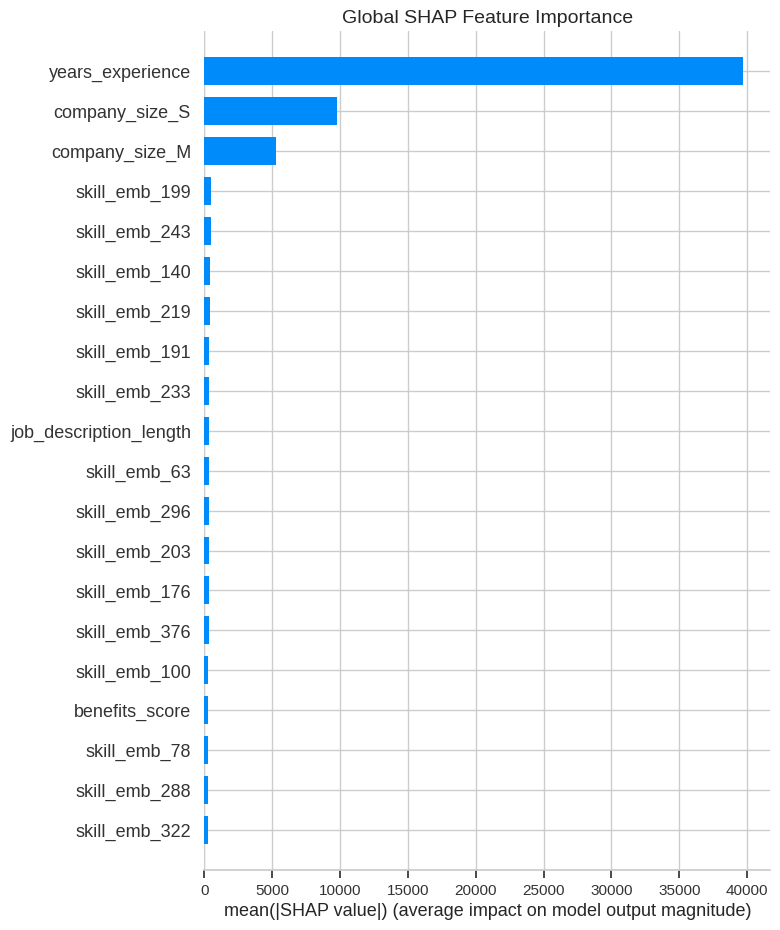


🔍 Local Explanations for First 3 Predictions:



📌 Sample #0



📌 Sample #1



📌 Sample #2



🧠 Red = pushes prediction ↑, Blue = pushes prediction ↓ from base value.


In [13]:
# ------------------- Install SHAP -------------------
!pip install shap --quiet

# ------------------- Imports -------------------
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from IPython.display import display

# ------------------- Configuration -------------------
X_FILENAME = 'X_final_selected_features.pkl'
N_LOCAL_EXPLANATIONS = 3       # Number of individual predictions to explain
MAX_ROWS_FOR_SHAP = 2000       # Sampling threshold to avoid SHAP slowness

# ------------------- Utility Functions -------------------
def find_latest_model_file(pattern='final_tuned_model_*.pkl', search_dir='.'):
    """Finds the most recently saved model file."""
    try:
        list_of_files = glob.glob(os.path.join(search_dir, pattern))
        if not list_of_files:
            return None
        return max(list_of_files, key=os.path.getctime)
    except Exception as e:
        print(f"Error finding model file: {e}")
        return None

def load_model_and_data(model_path, data_path):
    """Loads model and final features."""
    print("📥 Loading final tuned model and feature set...")
    if not os.path.exists(model_path) or not os.path.exists(data_path):
        raise FileNotFoundError("❌ Required model or data file not found.")
    model = joblib.load(model_path)
    X = joblib.load(data_path)
    print(f"✅ Loaded model: '{model_path}'\n✅ Feature shape: {X.shape}")
    return model, X

def reduce_data_if_needed(X, threshold=MAX_ROWS_FOR_SHAP):
    """Reduces dataset size for SHAP if needed."""
    if X.shape[0] > threshold:
        print(f"⚠️ SHAP may be slow on large datasets. Sampling {threshold} rows...")
        return X.sample(threshold, random_state=42)
    return X

def calculate_shap_values(model, X):
    """Computes SHAP values."""
    print("\n⚙️ Calculating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    print("✅ SHAP values calculated.")
    return explainer, shap_values

def plot_global_summary(shap_values, X):
    """Plots global feature importance using SHAP."""
    print("\n📊 Global Feature Importance Summary:")
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title("Global SHAP Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()

def display_top_features(shap_values, X, top_n=5):
    """Prints top N important features numerically."""
    print(f"\n🏆 Top {top_n} Most Influential Features:")
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_feats = pd.Series(mean_abs_shap, index=X.columns).sort_values(ascending=False).head(top_n)
    display(top_feats.to_frame("Mean |SHAP| Value"))

def plot_local_force_plots(explainer, shap_values, X, num_samples=N_LOCAL_EXPLANATIONS):
    """Plots SHAP force plots for individual predictions."""
    print(f"\n🔍 Local Explanations for First {num_samples} Predictions:")
    shap.initjs()
    for i in range(num_samples):
        print(f"\n📌 Sample #{i}")
        display(shap.force_plot(
            explainer.expected_value,
            shap_values[i],
            X.iloc[i],
            matplotlib=False
        ))
    print("\n🧠 Red = pushes prediction ↑, Blue = pushes prediction ↓ from base value.")

# ------------------- Main Execution -------------------
if __name__ == '__main__':
    try:
        latest_model_file = find_latest_model_file()
        if not latest_model_file:
            raise FileNotFoundError("No model file found. Please ensure it's named 'final_tuned_model_*.pkl'.")

        model, X_full = load_model_and_data(latest_model_file, X_FILENAME)
        X_explain = reduce_data_if_needed(X_full)

        print(f"\n🔎 Explaining model of type: {type(model).__name__}")

        explainer, shap_vals = calculate_shap_values(model, X_explain)

        display_top_features(shap_vals, X_explain)
        plot_global_summary(shap_vals, X_explain)
        plot_local_force_plots(explainer, shap_vals, X_explain)

    except FileNotFoundError as e:
        print(e)
    except Exception as err:
        print(f"❌ Unexpected error: {err}")


📥 Loading model and data...
✅ Loaded model: 'final_tuned_model_20250730_185635.pkl'

🔬 Explaining prediction for sample index: 0

📄 Human-Readable Explanation:



📊 SHAP Waterfall Plot:


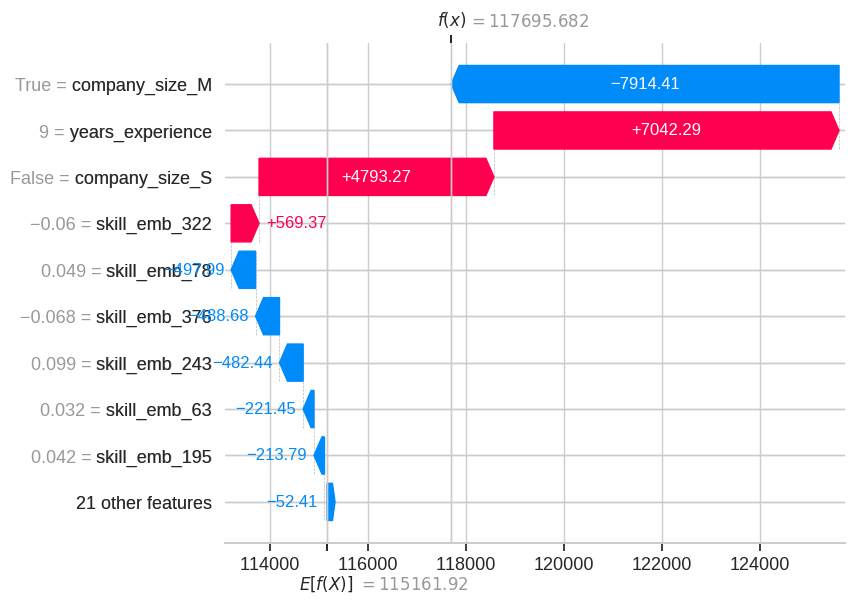

In [14]:
# shap_explanation.py
import pandas as pd
import shap
import joblib
import os
import glob
import numpy as np
from IPython.display import display, HTML

# ------------------- Configuration -------------------
X_FILENAME = 'X_final_selected_features.pkl'
SAMPLE_INDEX_TO_EXPLAIN = 0  # Index of the row to explain
TOP_FEATURES_TO_SHOW = 4     # Number of top features in explanation

# ------------------- Utility Functions -------------------
def find_latest_model_file(pattern='final_tuned_model_*.pkl'):
    try:
        list_of_files = glob.glob(pattern)
        return max(list_of_files, key=os.path.getctime) if list_of_files else None
    except Exception as e:
        print(f"⚠️ Error finding model file: {e}")
        return None

def load_model_and_data(model_path, data_path):
    print("📥 Loading model and data...")
    if not model_path or not os.path.exists(model_path) or not os.path.exists(data_path):
        raise FileNotFoundError("❌ Required model or data file not found.")
    model = joblib.load(model_path)
    X = joblib.load(data_path)
    print(f"✅ Loaded model: '{os.path.basename(model_path)}'")
    return model, X

def format_feature_name(feature_name):
    parts = feature_name.split('_')
    if "emb" in parts[1]:
        return f"NLP Signal for {parts[0].title()} (Dimension {parts[2]})"
    if len(parts) > 2 and parts[-2].isupper():
        return f"{' '.join(parts[:-1]).title()}: {parts[-1]}"
    return feature_name.replace('_', ' ').title()

def generate_text_explanation(explainer, shap_values_sample, features_sample, top_n):
    base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    predicted_value = base_value + shap_values_sample.sum()

    feature_impacts = pd.DataFrame({
        'shap_value': shap_values_sample,
        'value': features_sample.values
    }, index=features_sample.index)
    feature_impacts['abs_shap'] = feature_impacts['shap_value'].abs()
    top_impacts = feature_impacts.sort_values('abs_shap', ascending=False).head(top_n)

    explanation_html = f"""
    <style>
        ul {{ margin-top: 0; padding-left: 20px; }}
        h4 {{ margin-bottom: 5px; color: #444; }}
        li {{ margin-bottom: 6px; }}
    </style>
    <div style="font-family: Arial, sans-serif; line-height: 1.6;">
        <p>The model's base prediction starts at <b>${base_value:,.0f}</b>.</p>
        <p>After accounting for this candidate's features, the final predicted salary is <b>${predicted_value:,.0f}</b>.</p>
        <p>Here are the top {top_n} factors that influenced this prediction:</p>
    """

    positive_html = ""
    negative_html = ""

    for feature, row in top_impacts.iterrows():
        clean_name = format_feature_name(feature)
        value = row['value']
        if isinstance(value, (int, float)) and value not in [0, 1]:
            value_text = f" (Value: {value:.2f})"
        else:
            value_text = f" (Value: {value})" if value not in [0, 1] else ""

        if row['shap_value'] > 0:
            positive_html += f"<li><b>{clean_name}</b>{value_text} <font color='red'>increased</font> the prediction by <b>${abs(row['shap_value']):,.0f}</b>.</li>"
        else:
            negative_html += f"<li><b>{clean_name}</b>{value_text} <font color='blue'>decreased</font> the prediction by <b>${abs(row['shap_value']):,.0f}</b>.</li>"

    if positive_html:
        explanation_html += f"<h4>Factors that Increased the Salary:</h4><ul>{positive_html}</ul>"
    if negative_html:
        explanation_html += f"<h4>Factors that Decreased the Salary:</h4><ul>{negative_html}</ul>"

    explanation_html += "</div>"
    return explanation_html

# ------------------- Main Execution Block -------------------
if __name__ == '__main__':
    try:
        latest_model = find_latest_model_file()
        model, X = load_model_and_data(latest_model, X_FILENAME)

        X_sample = X.iloc[[SAMPLE_INDEX_TO_EXPLAIN]]
        print(f"\n🔬 Explaining prediction for sample index: {SAMPLE_INDEX_TO_EXPLAIN}")

        explainer = shap.TreeExplainer(model)
        shap_values_all = explainer.shap_values(X_sample)
        shap_values_sample = shap_values_all[0] if isinstance(shap_values_all, list) else shap_values_all[0]

        explanation_html = generate_text_explanation(
            explainer,
            shap_values_sample,
            X_sample.iloc[0],
            top_n=TOP_FEATURES_TO_SHOW
        )

        print("\n📄 Human-Readable Explanation:")
        display(HTML(explanation_html))

        print("\n📊 SHAP Waterfall Plot:")
        shap.initjs()
        shap.plots.waterfall(shap.Explanation(
            values=shap_values_sample,
            base_values=explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
            data=X_sample.iloc[0],
            feature_names=X_sample.columns
        ))

    except FileNotFoundError as e:
        print(e)
    except Exception as err:
        print(f"❌ An unexpected error occurred: {err}")


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import os

# Path to your WorthSyncProject folder
project_path = '/content/drive/MyDrive/WorthSyncProject'

# Change working directory
os.chdir(project_path)

# Optional: Check files
!ls


final_tuned_model_20250729_184216.pkl  X_final_selected_features.pkl
worthsync_app.py


In [17]:
!pip install streamlit shap sentence-transformers joblib --quiet
!pip install pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [18]:
from pyngrok import ngrok
from google.colab import userdata

# Kill any previous tunnels
ngrok.kill()

# Set token from Secrets Manager
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)


In [19]:
# @title
%%writefile worthsync_app.py
# ------------------- Imports -------------------
import os
import streamlit as st
import pandas as pd
import joblib
import glob
import shap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import streamlit.components.v1 as components
import numpy as np

st.set_page_config(page_title="WorthSync: AI Salary Intelligence", layout="wide", initial_sidebar_state="expanded")

@st.cache_resource
def load_resources():
    with st.spinner("Loading AI models and resources... Please wait."):
        model_pattern = 'final_tuned_model_*.pkl'
        list_of_files = glob.glob(model_pattern)
        if not list_of_files:
            return None, None, None, None
        latest_model_file = max(list_of_files, key=os.path.getctime)
        model = joblib.load(latest_model_file)
        features_list = joblib.load('X_final_selected_features.pkl').columns.tolist()
        nlp_model = SentenceTransformer('all-MiniLM-L6-v2')
        explainer = shap.TreeExplainer(model)
    return model, features_list, nlp_model, explainer

def generate_text_explanation(explainer, shap_values_sample, features_sample, top_n=5):
    base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    predicted_value = base_value + shap_values_sample.sum()

    feature_impacts = pd.DataFrame({
        'shap_value': shap_values_sample,
        'value': features_sample.values
    }, index=features_sample.index)
    feature_impacts['abs_shap'] = feature_impacts['shap_value'].abs()
    top_impacts = feature_impacts.sort_values('abs_shap', ascending=False).head(top_n)

    explanation_html = f"""
    <div style="font-family: Arial, sans-serif; line-height: 1.4;">
        <p>The model's base prediction starts at <b>${base_value:,.0f}</b>.</p>
        <p>The predicted salary for this profile is <b>${predicted_value:,.0f}</b>.</p>
        <p>Top factors influencing this prediction:</p>
        <ul>
    """

    for feature, row in top_impacts.iterrows():
        sign = "increased" if row['shap_value'] > 0 else "decreased"
        color = "red" if row['shap_value'] > 0 else "blue"
        explanation_html += f"<li><b>{feature}</b> (value: {row['value']}) <span style='color:{color}'>{sign}</span> the salary by <b>${abs(row['shap_value']):,.0f}</b>.</li>"

    explanation_html += "</ul></div>"
    return explanation_html

model, features, nlp_model, explainer = load_resources()

st.sidebar.title("💼 About WorthSync")
st.sidebar.info(
    "**WorthSync** is your AI-powered partner for salary prediction, designed for both employers and job seekers. "
    "Using advanced NLP and machine learning models, it delivers accurate, data-driven insights on compensation."
)
st.sidebar.header("🚀 How It Works")
st.sidebar.markdown("""
1. **Enter Profile:** Provide job details, skills, and background.
2. **AI Processing:** Your input is converted into numerical features, including NLP embeddings.
3. **Get Salary Insight:** See a smart salary estimate and an explanation of the key factors that influenced it.
""")

st.title("🔍 WorthSync: AI Salary Intelligence")
st.markdown("#### Aligning Compensation Expectations — For Employers and Talent Alike")

if model is None:
    st.error("Model resources could not be loaded. Please ensure the necessary files are in the directory and restart.")
else:
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("🎓 Your Professional Profile")
        job_title = st.text_input("Job Title", "AI Research Scientist")
        years_experience = st.slider("Years of Experience", 0, 40, 5)
        education_required = st.selectbox("Highest Education Level", ('Bachelor', 'Master', 'PhD', 'Associate'))

    with col2:
        st.subheader("🏢 Role & Company Info")
        experience_level = st.selectbox("Experience Level", ('EN', 'MI', 'SE', 'EX'), index=2)
        company_size = st.selectbox("Company Size", ('S', 'M', 'L'), index=1)
        job_description_length = st.slider("Job Description Length (approx. words)", 100, 2500, 1200)

    st.subheader("🧠 Your Skills")
    skills = st.text_area("Key Skills (comma-separated)", "Python, PyTorch, AWS, NLP, Computer Vision, SQL")

    if st.button("📊 Predict Salary"):
        with st.spinner('Analyzing your profile and running the prediction...'):
            input_df = pd.DataFrame(0, index=[0], columns=features)
            input_df['years_experience'] = years_experience
            input_df['job_description_length'] = job_description_length
            if f'experience_level_{experience_level}' in features:
                input_df[f'experience_level_{experience_level}'] = 1
            if f'company_size_{company_size}' in features:
                input_df[f'company_size_{company_size}'] = 1
            if f'education_required_{education_required}' in features:
                input_df[f'education_required_{education_required}'] = 1

            title_emb = nlp_model.encode([job_title])
            skill_emb = nlp_model.encode([skills])
            for i in range(title_emb.shape[1]):
                col = f'title_emb_{i}'
                if col in features:
                    input_df[col] = title_emb[0, i]
            for i in range(skill_emb.shape[1]):
                col = f'skill_emb_{i}'
                if col in features:
                    input_df[col] = skill_emb[0, i]

            prediction = model.predict(input_df[features])[0]
            shap_values = explainer.shap_values(input_df[features])[0]

            st.success(f"### 💰 Predicted Annual Salary: **${prediction:,.0f} USD**")
            st.markdown("---")
            st.subheader("💡 Explanation of Your Prediction")
            st.write("This chart shows the factors that influenced your salary estimate. Red bars pushed the prediction up, while blue bars pushed it down.")

            # SHAP Waterfall Plot (matplotlib)
            shap_explanation = shap.Explanation(
                values=shap_values,
                base_values=explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                data=input_df.iloc[0],
                feature_names=input_df.columns
            )
            fig, ax = plt.subplots(figsize=(10, 6))
            shap.plots.waterfall(shap_explanation, max_display=10, show=False)
            st.pyplot(fig)

            # Textual explanation below the plot
            explanation_html = generate_text_explanation(explainer, shap_values, input_df.iloc[0], top_n=5)
            components.html(explanation_html, height=280, scrolling=True)

            st.caption("This estimate is based on industry data and AI interpretation. Actual salary may vary.")


Overwriting worthsync_app.py


In [20]:
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

!streamlit run worthsync_app.py --server.enableCORS false --server.enableXsrfProtection false --server.port=8501


Streamlit App URL: NgrokTunnel: "https://f965526b067c.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.79.129:8501

  Stopping...
^C


In [21]:
# Install pyngrok silently
!pip install pyngrok --quiet

from pyngrok import ngrok
import getpass

# Terminate any existing tunnels
ngrok.kill()

# 🔐 Securely prompt for ngrok token (not stored in notebook)
print("🔐 Please enter your own ngrok authtoken.")
print("💡 Get it here: https://dashboard.ngrok.com/get-started/your-authtoken")
NGROK_AUTH_TOKEN = getpass.getpass("Paste your ngrok token here: ")

if not NGROK_AUTH_TOKEN:
    raise ValueError("❌ Ngrok token not provided. Cannot start app.")
else:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("✅ ngrok token set successfully.")

# Launch the Streamlit app
public_url = ngrok.connect(8501)
print(f"\n🚀 Your Streamlit app is live! URL: {public_url}")

# Start the Streamlit app (run in background)
!streamlit run worthsync_app.py --server.enableCORS false --server.enableXsrfProtection false --server.port=8501 &


KeyboardInterrupt: 